In [ ]:
# #defininf arc, and training
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.layers import Conv2D, Add, Conv2DTranspose, Concatenate, LeakyReLU, Subtract, Input, Dropout, Flatten, Dense
# from tensorflow.keras.models import Model
# from tensorflow.keras.applications import EfficientNetB0
# #visualisations , calculation of losses, and loading images
# import matplotlib.pyplot as plt
# import numpy as np
# import os
# from tensorflow.keras.mixed_precision import set_global_policy, Policy

# # Set the mixed precision policy to use float16
# policy = Policy('mixed_float16')
# set_global_policy(policy)


# # Parameters for handling
# input_shape = (500, 500, 3)
# n_filters = 32

# # Linear CNN block
# def dncnn_block(layer, filters,initializer, kernel_size=3, padding='same'):
#     layer = Conv2D(filters, kernel_size=kernel_size, padding=padding, kernel_initializer=initializer, use_bias=True)(layer)
#     layer = InstanceNormalization()(layer)
#     layer = LeakyReLU(alpha=0.2)(layer)
#     return layer

# # Instance normalization for CycleGAN better for this training method over the standard batch norm
# class InstanceNormalization(tf.keras.layers.Layer):
#     def __init__(self, epsilon=1e-5, **kwargs):
#         super().__init__(**kwargs)
#         self.epsilon = epsilon

#     def build(self, input_shape):
#         self.gamma = self.add_weight(shape=(input_shape[-1],), initializer='ones', trainable=True, name='gamma')
#         self.beta = self.add_weight(shape=(input_shape[-1],), initializer='zeros', trainable=True, name='beta')
#         super().build(input_shape)

#     def call(self, inputs, training=False):
#         mean, variance = tf.nn.moments(inputs, axes=[1, 2], keepdims=True)
#         normalized = (inputs - mean) / tf.sqrt(variance + self.epsilon)
#         return self.gamma * normalized + self.beta

#     def get_config(self):
#         config = super().get_config().copy()
#         config.update({'epsilon': self.epsilon})
#         return config

# # Residual block for generators
# def residual_block(layer, filters,initializer, kernel_size=3, strides=1, padding='same'):
#     shortcut = layer
#     layer = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding=padding,kernel_initializer=initializer)(layer)
#     layer = InstanceNormalization()(layer)
#     layer = LeakyReLU(alpha=0.2)(layer)
#     layer = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding=padding,kernel_initializer=initializer)(layer)
#     layer = InstanceNormalization()(layer)
#     if layer.shape[-1] != shortcut.shape[-1]:
#         shortcut = Conv2D(filters, kernel_size=1, strides=strides, padding='same',kernel_initializer=initializer)(shortcut)
#         shortcut = InstanceNormalization()(shortcut)
#     layer = Add()([layer, shortcut])
#     layer = LeakyReLU(alpha=0.2)(layer)
#     return layer

# #channel attention mechanism(for dncnn blocks)
# def lightweight_channel_attention(x, reduction_ratio=8):
#     # Get the input channel dimension
#     channel_dim = x.shape[-1]

#     # Squeeze: Global Average Pooling
#     squeezed = tf.keras.layers.GlobalAveragePooling2D()(x)

#     # Reduce the channels by reduction_ratio, then restore it
#     reduced_channels = max(1, channel_dim // reduction_ratio)
#     fc1 = Dense(reduced_channels, activation='relu')(squeezed)  # Reduced channels
#     fc2 = Dense(channel_dim, activation='sigmoid')(fc1)  # Restore original channels

#     # Reshape for channel-wise multiplication
#     scale = tf.keras.layers.Reshape((1, 1, channel_dim))(fc2)

#     # Scale the input tensor with the attention weights
#     return tf.keras.layers.Multiply()([x, scale])

# #self attention mechanism
# def self_attention_block(x, filters):
#     f = Conv2D(filters // 8, kernel_size=1, strides=1, padding='same')(x)  # Key
#     g = Conv2D(filters // 8, kernel_size=1, strides=1, padding='same')(x)  # Query
#     h = Conv2D(filters, kernel_size=1, strides=1, padding='same')(x)       # Value

#     # Calculate attention
#     gamma = tf.keras.layers.Dot(axes=[3, 3])([g, f])                      # (batch, h, w, w)
#     gamma = tf.keras.layers.Softmax(axis=-1)(gamma)

#     o = tf.keras.layers.Dot(axes=[3, 2])([gamma, h])                       # (batch, h, w, c)
#     o = Conv2D(filters, kernel_size=1, strides=1, padding='same')(o)

#     # Scaling
#     o = tf.keras.layers.Add()([o, x])
#     return o


# def build_model_generator(input_shape, n_filters):
#     initializer = tf.random_normal_initializer(0., 0.02)

#     input_layer = Input(input_shape)

#     # Downsampling
#     d0 = dncnn_block(input_layer, n_filters, initializer)
#     d0 = residual_block(d0, n_filters, initializer)
#     d0 = Conv2D(n_filters*2 , kernel_size=3, strides=2, padding='same',kernel_initializer=initializer, use_bias=True, activation='relu')(d0)  # Size halved
#     d0_skip = dncnn_block(d0,n_filters*2, initializer)

#     d1 = dncnn_block(d0, n_filters*2, initializer)
#     d1 = residual_block(d1, n_filters*2, initializer)
#     d1 = Conv2D(n_filters*4, kernel_size=3, strides=2, padding='same',kernel_initializer=initializer, use_bias=True, activation='relu')(d1)  # Size halved
#     d1_skip = dncnn_block(d1,n_filters*4, initializer)

#     d2 = dncnn_block(d1, n_filters*4, initializer )
#     d2 = residual_block(d2, n_filters*4, initializer)
#     d2 = Conv2D(n_filters*8,kernel_size=3, strides=2, padding='same',kernel_initializer=initializer, use_bias=True, activation='relu')(d2)   # Size halved
#     d2_skip = dncnn_block(d2,n_filters*8, initializer)

#     # Bottleneck
#     # plan to implement self attention at this point
#     b = residual_block(d2, n_filters*16 , initializer)
#     b = self_attention_block(b, n_filters * 16) #self attention to relate global dependencies
#     b = dncnn_block(b, n_filters*8, initializer)

#     # Upsampling
#     u2 = Concatenate()([b, d2_skip])
#     u2 = Conv2DTranspose(n_filters*8 , kernel_size=3, strides=2, padding='same',kernel_initializer=initializer)(u2)  # Size doubled
#     u2 = residual_block(u2, n_filters*8 , initializer)
#     u2 = dncnn_block(u2, n_filters*4 , initializer)


#     u1 = Concatenate()([layers.Cropping2D(cropping=((0,1),(0,1)))(u2), d1_skip])
#     u1 = Conv2DTranspose(n_filters*4 , kernel_size=3, strides=2, padding='same',kernel_initializer=initializer)(u1)  # Size doubled
#     u1 = residual_block(u1, n_filters*4 , initializer)
#     u1 = dncnn_block(u1, n_filters*2, initializer)


#     u0 = Concatenate()([u1, d0_skip])
#     u0 = Conv2DTranspose(n_filters*2, kernel_size=3, strides=2, padding='same',kernel_initializer=initializer)(u0)  # Size doubled
#     u0 = residual_block(u0, n_filters*2, initializer)
#     u0 = dncnn_block(u0, n_filters, initializer)

#     # Output of predicted noise
#     output_layer = Conv2D(input_shape[-1], kernel_size=1, activation='sigmoid',kernel_initializer=initializer)(u0)
#     #remove the noise from the images giving the final prediction
#     #output_layer = Subtract()([input_layer, noise])

#     model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
#     return model

In [ ]:
#defininf arc, and training
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Add, Conv2DTranspose, Concatenate, LeakyReLU, Subtract, Input, Dropout
from tensorflow.keras.layers import Layer, Conv2D, Add, Softmax, Multiply,  BatchNormalization, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
#visualisations , calculation of losses, and loading images
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.mixed_precision import set_global_policy, Policy

# Set the mixed precision policy to use float16
policy = Policy('mixed_float16')
set_global_policy(policy)


# Parameters for handling
input_shape = (500, 500, 3)
n_filters = 32

# Linear CNN block
def dncnn_block(layer, filters, initializer, kernel_size=3, padding='same'):
    # Basic Conv2D + Instance Normalization + LeakyReLU
    layer = Conv2D(filters, kernel_size=kernel_size, padding=padding, kernel_initializer=initializer, use_bias=True)(layer)
    layer = InstanceNormalization()(layer)
    layer = LeakyReLU(alpha=0.05)(layer)

    # Add lightweight channel attention
    layer = lightweight_channel_attention(layer)

    return layer


# Instance normalization for CycleGAN better for this training method over the standard batch norm
class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5, **kwargs):
        super().__init__(**kwargs)
        self.epsilon = epsilon

    def build(self, input_shape):
        self.gamma = self.add_weight(shape=(input_shape[-1],), initializer='ones', trainable=True, name='gamma')
        self.beta = self.add_weight(shape=(input_shape[-1],), initializer='zeros', trainable=True, name='beta')
        super().build(input_shape)

    def call(self, inputs, training=False):
        mean, variance = tf.nn.moments(inputs, axes=[1, 2], keepdims=True)
        normalized = (inputs - mean) / tf.sqrt(variance + self.epsilon)
        return self.gamma * normalized + self.beta

    def get_config(self):
        config = super().get_config().copy()
        config.update({'epsilon': self.epsilon})
        return config

# Residual block for generators
def residual_block(layer, filters,initializer, kernel_size=3, strides=1, padding='same'):
    shortcut = layer
    layer = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding=padding,kernel_initializer=initializer)(layer)
    layer = InstanceNormalization()(layer)
    layer = LeakyReLU(alpha=0.05)(layer)
    layer = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding=padding,kernel_initializer=initializer)(layer)
    layer = InstanceNormalization()(layer)
    if layer.shape[-1] != shortcut.shape[-1]:
        shortcut = Conv2D(filters, kernel_size=1, strides=strides, padding='same',kernel_initializer=initializer)(shortcut)
        shortcut = InstanceNormalization()(shortcut)
    layer = Add()([layer, shortcut * 0.1])
    layer = LeakyReLU(alpha=0.05)(layer)
    return layer

#channel attention mechanism(for dncnn blocks)
def lightweight_channel_attention(x, reduction_ratio=4):
    # Get the input channel dimension
    channel_dim = x.shape[-1]

    # Squeeze: Global Average Pooling
    squeezed = tf.keras.layers.GlobalAveragePooling2D()(x)

    # Reduce the channels by reduction_ratio, then restore it
    reduced_channels = max(1, channel_dim // reduction_ratio)
    fc1 = Dense(reduced_channels, activation='relu')(squeezed)  # Reduced channels
    fc2 = Dense(channel_dim, activation='sigmoid')(fc1)  # Restore original channels

    # Reshape for channel-wise multiplication
    scale = tf.keras.layers.Reshape((1, 1, channel_dim))(fc2)
    scale = tf.keras.layers.Multiply()([x, scale])
    scake = BatchNormalization()(scale)
    # Scale the input tensor with the attention weights
    return scake

class SelfAttentionLayer(Layer):
    def __init__(self, filters):
        super(SelfAttentionLayer, self).__init__()
        self.filters = filters
        self.conv_f = Conv2D(filters // 8, kernel_size=1, strides=1, padding='same')
        self.conv_g = Conv2D(filters // 8, kernel_size=1, strides=1, padding='same')
        self.conv_h = Conv2D(filters, kernel_size=1, strides=1, padding='same')

    def call(self, x):
        # Calculate Key, Query, and Value
        f = self.conv_f(x)  # Key
        g = self.conv_g(x)  # Query
        h = self.conv_h(x)  # Value

        # Calculate attention
        gamma = tf.keras.layers.Dot(axes=[3, 3])([g, f])  # (batch, h, w, h, w)
        gamma = Softmax(axis=-1)(gamma)                    # Apply softmax to attention weights

        # Reshape gamma and h
        gamma_reshaped = tf.reshape(gamma, (-1, 63 * 63, 63 * 63))  # Flatten spatial dimensions
        h_flat = tf.reshape(h, (-1, 63 * 63, 512))                  # Flatten h

        # Apply attention weights
        o = tf.matmul(gamma_reshaped, h_flat)                   # (batch, h*w, 512)

        # Reshape o back to spatial dimensions
        o = tf.reshape(o, (-1, 63, 63, 512))

        # Scaling and residual connection
        o = Add()([o, x])
        return o



def build_model_generator(input_shape, n_filters):
    initializer = tf.random_normal_initializer(0., 0.02)

    input_layer = Input(input_shape)

    # Downsampling
    d0 = dncnn_block(input_layer, n_filters, initializer)
    d0 = residual_block(d0, n_filters, initializer)
    d0 = Conv2D(n_filters*2 , kernel_size=3, strides=2, padding='same',kernel_initializer=initializer, use_bias=True, activation='relu')(d0)  # Size halved
    d0_skip = dncnn_block(d0,n_filters*2, initializer)

    d1 = dncnn_block(d0, n_filters*2, initializer)
    d1 = residual_block(d1, n_filters*2, initializer)
    d1 = Conv2D(n_filters*4, kernel_size=3, strides=2, padding='same',kernel_initializer=initializer, use_bias=True, activation='relu')(d1)  # Size halved
    d1_skip = dncnn_block(d1,n_filters*4, initializer)

    d2 = dncnn_block(d1, n_filters*4, initializer )
    d2 = residual_block(d2, n_filters*4, initializer)
    d2 = Conv2D(n_filters*8,kernel_size=3, strides=2, padding='same',kernel_initializer=initializer, use_bias=True, activation='relu')(d2)   # Size halved
    d2_skip = dncnn_block(d2,n_filters*8, initializer)

    # Bottleneck
    # plan to implement self attention at this point  initialize object
    attention_layer = SelfAttentionLayer(n_filters * 16)


    b = residual_block(d2, n_filters*16 , initializer)
 #   b = attention_layer(b) #self attention to relate global dependencies
    b = dncnn_block(b, n_filters*8, initializer)

    # Upsampling
    u2 = Concatenate()([b, d2_skip])
    u2 = Conv2DTranspose(n_filters*8 , kernel_size=3, strides=2, padding='same',kernel_initializer=initializer)(u2)  # Size doubled
    u2 = residual_block(u2, n_filters*8 , initializer)
    u2 = dncnn_block(u2, n_filters*4 , initializer)


    u1 = Concatenate()([layers.Cropping2D(cropping=((0,1),(0,1)))(u2), d1_skip])
    u1 = Conv2DTranspose(n_filters*4 , kernel_size=3, strides=2, padding='same',kernel_initializer=initializer)(u1)  # Size doubled
    u1 = residual_block(u1, n_filters*4 , initializer)
    u1 = dncnn_block(u1, n_filters*2, initializer)


    u0 = Concatenate()([u1, d0_skip])
    u0 = Conv2DTranspose(n_filters*2, kernel_size=3, strides=2, padding='same',kernel_initializer=initializer)(u0)  # Size doubled
    u0 = residual_block(u0, n_filters*2, initializer)
    u0 = dncnn_block(u0, n_filters, initializer)

    # Output of predicted noise
    output_layer = Conv2D(input_shape[-1], kernel_size=1, activation='sigmoid',kernel_initializer=initializer)(u0)
    #remove the noise from the images giving the final prediction
    #output_layer = Subtract()([input_layer, noise])

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    return model



In [ ]:

def build_patchgan_discriminator(input_shape,n_filters=64):

    initializer = tf.random_normal_initializer(0., 0.02)

    input_layer = layers.Input(shape=input_shape)

    d = layers.Conv2D(n_filters, (4, 4), strides=2, padding='same', kernel_initializer=initializer)(input_layer)
    d = layers.LeakyReLU(alpha=0.2)(d)

    d = layers.Conv2D(n_filters*2, (4, 4), strides=2, padding='same', kernel_initializer=initializer)(d)
    d = InstanceNormalization()(d)
    d = layers.LeakyReLU(alpha=0.2)(d)

    d = layers.Conv2D(n_filters*4, (4, 4), strides=2, padding='same', kernel_initializer=initializer)(d)
    d = InstanceNormalization()(d)
    d = layers.LeakyReLU(alpha=0.2)(d)

    d = layers.Conv2D(n_filters*8, (4, 4), strides=2, padding='same', kernel_initializer=initializer)(d)
    d = InstanceNormalization()(d)
    d = layers.LeakyReLU(alpha=0.2)(d)

    d = layers.Conv2D(1, (4, 4), strides=1, padding='same', kernel_initializer=initializer)(d)

    output_layer = layers.Activation('sigmoid')(d)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    return model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
extractor_model = EfficientNetB0(weights='imagenet', include_top=False)

In [ ]:
import tensorflow as tf

# Discriminator loss
def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)(tf.ones_like(real_output, dtype=tf.float32), real_output)
    fake_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)(tf.zeros_like(fake_output, dtype=tf.float32), fake_output)
    return real_loss + fake_loss

# Generator loss
def generator_loss(fake_output):
    return tf.keras.losses.BinaryCrossentropy(from_logits=False)(tf.ones_like(fake_output, dtype=tf.float32), fake_output)

# SSIM loss
def ssim_loss(real_image, generated_image):
    eps = 1e-8
   # Ensure images are float32
    real_image = tf.cast(real_image, tf.float32)
    generated_image = tf.cast(generated_image, tf.float32)
    # Convert to [0, 1] range
    real_image = (real_image + 1.0) / 2.0
    generated_image = (generated_image + 1.0) / 2.0

    return 1 - tf.reduce_mean(tf.image.ssim(real_image, generated_image, max_val=1.0) + eps)

# Perceptual loss
def perceptual_loss(real_image, generated_image):
    eps = 1e-8
    real_image = tf.image.resize(real_image, (224, 224))
    generated_image = tf.image.resize(generated_image, (224, 224))

    # Ensure images are float32
    real_image = tf.cast(real_image, tf.float32)
    generated_image = tf.cast(generated_image, tf.float32)

    real_features = extractor_model(real_image)
    generated_features = extractor_model(generated_image)

    loss = tf.reduce_mean(tf.square(real_features - generated_features) + eps)  # L2 loss between feature maps
    return loss

# Cycle consistency loss
def cycle_loss(real_image, cycled_image, lambda_cycle=2.0, lambda_perceptual=1.0, lambda_ssim=1.0):
    eps = 1e-8

    # Ensure images are float32
    real_image = tf.cast(real_image, tf.float32)
    cycled_image = tf.cast(cycled_image, tf.float32)

    l1_loss = tf.reduce_mean(tf.abs(real_image - cycled_image) + eps)
    perceptual_loss_value = perceptual_loss(real_image, cycled_image)
    ssim_loss_value = ssim_loss(real_image, cycled_image)

    # Ensure all losses are float32
    l1_loss = tf.cast(l1_loss, tf.float32)
    perceptual_loss_value = tf.cast(perceptual_loss_value, tf.float32)
    ssim_loss_value = tf.cast(ssim_loss_value, tf.float32)

    # Ensure lambda values are float32
    lambda_cycle = tf.cast(lambda_cycle, tf.float32)
    lambda_perceptual = tf.cast(lambda_perceptual, tf.float32)
    lambda_ssim = tf.cast(lambda_ssim, tf.float32)

    total_cycle_loss = (lambda_cycle * l1_loss) + (lambda_perceptual * perceptual_loss_value) + (lambda_ssim * ssim_loss_value)
    return total_cycle_loss

# Identity loss
def identity_loss(real_image, identity_image, lambda_identity=2.0, lambda_perceptual=1.0, lambda_ssim=1.0):
    eps = 1e-8

    # Ensure images are float32
    real_image = tf.cast(real_image, tf.float32)
    identity_image = tf.cast(identity_image, tf.float32)

    l1_loss = tf.reduce_mean(tf.abs(real_image - identity_image) + eps)
    perceptual_loss_value = perceptual_loss(real_image, identity_image)
    ssim_loss_value = ssim_loss(real_image, identity_image)

    # Ensure all losses are float32
    l1_loss = tf.cast(l1_loss, tf.float32)
    perceptual_loss_value = tf.cast(perceptual_loss_value, tf.float32)
    ssim_loss_value = tf.cast(ssim_loss_value, tf.float32)

    # Ensure lambda values are float32
    lambda_identity = tf.cast(lambda_identity, tf.float32)
    lambda_perceptual = tf.cast(lambda_perceptual, tf.float32)
    lambda_ssim = tf.cast(lambda_ssim, tf.float32)

    total_identity_loss = (lambda_identity * l1_loss) + (lambda_perceptual * perceptual_loss_value) + (lambda_ssim * ssim_loss_value)
    return total_identity_loss


#define generators and discriminators
generator_AB = build_model_generator(input_shape,n_filters)
generator_BA = build_model_generator(input_shape,n_filters)
discriminator_A = build_patchgan_discriminator(input_shape,n_filters*2)
discriminator_B = build_patchgan_discriminator(input_shape,n_filters*2)
#define their respective optimizers

try:
    generator_AB.load_weights('/content/drive/MyDrive/saves/generator_AB.weights.h5')
    generator_BA.load_weights('/content/drive/MyDrive/saves/generator_BA.weights.h5')
    discriminator_A.load_weights('/content/drive/MyDrive/saves/discriminator_A.weights.h5')
    discriminator_B.load_weights('/content/drive/MyDrive/saves/discriminator_B.weights.h5')
    print("Weights loaded successfully.")
except Exception as e:
    print("No saved weights found. Starting fresh.")
    print(e)

generator_AB_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1.0)
generator_BA_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1.0)
discriminator_A_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1.0)
discriminator_B_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1.0)

No saved weights found. Starting fresh.
[Errno 2] Unable to synchronously open file (unable to open file: name = '/content/drive/MyDrive/saves/generator_AB.weights.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


In [ ]:
# Lists to store losses for plotting
gen_losses_AB = []
gen_losses_BA = []
disc_losses_A = []
disc_losses_B = []

@tf.function
def train_step(image_A, image_B, generator_AB, generator_BA, discriminator_A, discriminator_B,
               generator_AB_optimizer, generator_BA_optimizer, discriminator_A_optimizer, discriminator_B_optimizer,
               clip_value=1.0):  # Set a clipping threshold
    with tf.GradientTape() as gen_tape_AB, tf.GradientTape() as gen_tape_BA, tf.GradientTape() as disc_tape_A, tf.GradientTape() as disc_tape_B:

        # Generate fake images
        fake_image_B = generator_AB(image_A, training=True)
        fake_image_A = generator_BA(image_B, training=True)

        # Reconstruct images
        cycled_image_A = generator_BA(fake_image_B, training=True)
        cycled_image_B = generator_AB(fake_image_A, training=True)

        # Identity mapping
        identity_image_A = generator_BA(image_A, training=True)
        identity_image_B = generator_AB(image_B, training=True)

        # Discriminator outputs
        disc_real_A = discriminator_A(image_A, training=True)
        disc_real_B = discriminator_B(image_B, training=True)
        disc_fake_A = discriminator_A(fake_image_A, training=True)
        disc_fake_B = discriminator_B(fake_image_B, training=True)

        # Compute losses
        gen_loss_AB = generator_loss(disc_fake_B)
        gen_loss_BA = generator_loss(disc_fake_A)
        disc_loss_A = discriminator_loss(disc_real_A, disc_fake_A)
        disc_loss_B = discriminator_loss(disc_real_B, disc_fake_B)
        cycle_loss_A = cycle_loss(image_A, cycled_image_A)
        cycle_loss_B = cycle_loss(image_B, cycled_image_B)
        identity_loss_A = identity_loss(image_A, identity_image_A)
        identity_loss_B = identity_loss(image_B, identity_image_B)

        # Include cycle and identity losses in total generator loss
        gen_total_loss_AB = gen_loss_AB + cycle_loss_A + cycle_loss_B + identity_loss_A + identity_loss_B
        gen_total_loss_BA = gen_loss_BA + cycle_loss_A + cycle_loss_B + identity_loss_A + identity_loss_B

    # Compute gradients
    gradients_of_generator_AB = gen_tape_AB.gradient(gen_total_loss_AB, generator_AB.trainable_variables)
    gradients_of_generator_BA = gen_tape_BA.gradient(gen_total_loss_BA, generator_BA.trainable_variables)
    gradients_of_discriminator_A = disc_tape_A.gradient(disc_loss_A, discriminator_A.trainable_variables)
    gradients_of_discriminator_B = disc_tape_B.gradient(disc_loss_B, discriminator_B.trainable_variables)

    # Apply gradient clipping
    gradients_of_generator_AB = [tf.clip_by_value(g, -clip_value, clip_value) if g is not None else None for g in gradients_of_generator_AB]
    gradients_of_generator_BA = [tf.clip_by_value(g, -clip_value, clip_value) if g is not None else None for g in gradients_of_generator_BA]
    gradients_of_discriminator_A = [tf.clip_by_value(g, -clip_value, clip_value) if g is not None else None for g in gradients_of_discriminator_A]
    gradients_of_discriminator_B = [tf.clip_by_value(g, -clip_value, clip_value) if g is not None else None for g in gradients_of_discriminator_B]

    # Apply gradients
    generator_AB_optimizer.apply_gradients(zip(gradients_of_generator_AB, generator_AB.trainable_variables))
    generator_BA_optimizer.apply_gradients(zip(gradients_of_generator_BA, generator_BA.trainable_variables))
    discriminator_A_optimizer.apply_gradients(zip(gradients_of_discriminator_A, discriminator_A.trainable_variables))
    discriminator_B_optimizer.apply_gradients(zip(gradients_of_discriminator_B, discriminator_B.trainable_variables))

    return gen_total_loss_AB, gen_total_loss_BA, disc_loss_A, disc_loss_B, cycle_loss_A, cycle_loss_B, identity_loss_A, identity_loss_B


In [ ]:
def resize_image(image, target_size=(250, 250)):
    return tf.image.resize(image, target_size).numpy()

import numpy as np

class ImageBuffer:
    def __init__(self, max_size=50):
        self.max_size = max_size
        self.buffer = []

    def add_and_sample(self, new_images):
        """Add new images to the buffer and return a sample to be used in training."""
        sampled_images = []

        for img in new_images:
            if len(self.buffer) < self.max_size:
                # If buffer is not full, add the image
                self.buffer.append(img)
                sampled_images.append(img)
            else:
                # If buffer is full, randomly replace old images with a probability or use the new one
                if np.random.rand() > 0.5:
                    idx = np.random.randint(0, self.max_size)
                    sampled_images.append(self.buffer[idx])
                    self.buffer[idx] = img  # Replace an old image in the buffer
                else:
                    sampled_images.append(img)  # Use the new image

        return np.array(sampled_images)


import matplotlib.pyplot as plt

def plot_images(image_A, fake_image_B, cycled_image_A, real_image_B, fake_image_A, cycled_image_B):
    # Resize images for visualization
    resized_image_A = resize_image(image_A)
    resized_fake_image_B = resize_image(fake_image_B)
    resized_cycled_image_A = resize_image(cycled_image_A)
    resized_real_image_B = resize_image(real_image_B)
    resized_fake_image_A = resize_image(fake_image_A)
    resized_cycled_image_B = resize_image(cycled_image_B)

    # Remove the batch dimension (first dimension)
    images = [tf.squeeze(img) for img in [resized_image_A, resized_fake_image_B, resized_cycled_image_A,
                                           resized_real_image_B, resized_fake_image_A, resized_cycled_image_B]]

    # Create a figure with a specific size
    plt.figure(figsize=(12, 8))  # Adjust figsize as needed

    titles = ['Real Image A', 'Fake Image B', 'Cycled Image A',
              'Real Image B', 'Fake Image A', 'Cycled Image B']

    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i], vmin=0, vmax=1)
        plt.title(titles[i])
        plt.axis('off')

    plt.show()


# def denormalize(image):
#     if isinstance(image, tf.Tensor):
#         image = image.numpy()
#     if image.max() <= 1:  # Check if image values are in [0, 1]
#         image = (image * 255).astype(np.uint8)
#     return image

In [ ]:

from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt

# Define the number of steps for averaging and resetting the loss arrays (memory efficiency)
average_interval = 100
reset_interval = 270

def train(dataset_A, dataset_B, epochs, batch_size, steps_per_epoch,
          generator_AB=generator_AB, generator_BA=generator_BA, discriminator_A=discriminator_A, discriminator_B=discriminator_B,
          generator_AB_optimizer=generator_AB_optimizer, generator_BA_optimizer=generator_BA_optimizer, discriminator_A_optimizer=discriminator_A_optimizer, discriminator_B_optimizer=discriminator_B_optimizer):

    global gen_losses_AB, gen_losses_BA, disc_losses_A, disc_losses_B

    # Initialize image buffers for discriminator training
    buffer_A = ImageBuffer(max_size=50)
    buffer_B = ImageBuffer(max_size=50)

    for epoch in range(epochs):
        step=0
        for image_A, image_B in zip(dataset_A, dataset_B):
            step += 1
  #testing for model saves.
            #if(step == 200):
              #break;

            # Forward pass through generators and discriminators
            gen_loss_AB, gen_loss_BA, disc_loss_A, disc_loss_B, cycle_loss_A, cycle_loss_B, identity_loss_A, identity_loss_B = train_step(
                image_A, image_B, generator_AB, generator_BA, discriminator_A, discriminator_B,
                generator_AB_optimizer, generator_BA_optimizer, discriminator_A_optimizer, discriminator_B_optimizer
            )

            # Add generated images to the buffers and sample for discriminator training
            fake_image_A = generator_BA(image_B, training=True)
            fake_image_B = generator_AB(image_A, training=True)

            buffered_fake_A = buffer_A.add_and_sample(fake_image_A)
            buffered_fake_B = buffer_B.add_and_sample(fake_image_B)

            # Track losses
            gen_losses_AB.append(gen_loss_AB.numpy())
            gen_losses_BA.append(gen_loss_BA.numpy())
            disc_losses_A.append(disc_loss_A.numpy())
            disc_losses_B.append(disc_loss_B.numpy())

            # Print out training progress
            print(f'Epoch {epoch+1}/{epochs} - Step {step}/{steps_per_epoch} | GenAB: {gen_loss_AB.numpy():.4f} | GenBA: {gen_loss_BA.numpy():.4f} | DiscA: {disc_loss_A.numpy():.4f} | DiscB: {disc_loss_B.numpy():.4f} | CycleA: {cycle_loss_A.numpy():.4f} | CycleB: {cycle_loss_B.numpy():.4f} | IdA: {identity_loss_A.numpy():.4f} | IdB: {identity_loss_B.numpy():.4f}')


            # Display average loss every 10 steps
            if step % average_interval == 0:
                avg_gen_loss_AB = np.mean(gen_losses_AB)
                avg_gen_loss_BA = np.mean(gen_losses_BA)
                avg_disc_loss_A = np.mean(disc_losses_A)
                avg_disc_loss_B = np.mean(disc_losses_B)

                print(f'Average Losses at Step {step}:')
                print(f'  Generator Loss AB: {avg_gen_loss_AB}')
                print(f'  Generator Loss BA: {avg_gen_loss_BA}')
                print(f'  Discriminator Loss A: {avg_disc_loss_A}')
                print(f'  Discriminator Loss B: {avg_disc_loss_B}')
                print(f'Visualizing results at step {step}...')

                fake_image_B = generator_AB(image_A, training=False)
                cycled_image_A = generator_BA(fake_image_B, training=False)
                fake_image_A = generator_BA(image_B, training=False)
                cycled_image_B = generator_AB(fake_image_A, training=False)

                plot_images(image_A, fake_image_B, cycled_image_A, image_B, fake_image_A, cycled_image_B)

            # Visualization and reset every 100 steps
            if step % reset_interval == 0:
                # Reset lists to keep only the last value
                if len(gen_losses_AB) > 0:
                    gen_losses_AB = [gen_losses_AB[-1]]
                    gen_losses_BA = [gen_losses_BA[-1]]
                if len(disc_losses_A) > 0:
                    disc_losses_A = [disc_losses_A[-1]]
                    disc_losses_B = [disc_losses_B[-1]]

                clear_output(wait=True)

            if step % 500 == 0:
              path = f'/content/generator_AB_step{step}_epoch{epoch+1}.h5'
              generator_AB.save(path)
              print(f"✅ Saved generator_AB to: {path}")

        # Save the models at the end of each epoch
        generator_AB.save(f'/content/drive/MyDrive/saves/generator_AB.weights.h5')
        generator_BA.save(f'/content/drive/MyDrive/saves/generator_BA.weights.h5')
        discriminator_A.save(f'/content/drive/MyDrive/saves/discriminator_A.weights.h5')
        discriminator_B.save(f'/content/drive/MyDrive/saves/discriminator_B.weights.h5')

        print(f'Epoch {epoch+1} completed.')

Epoch 1/50 - Step 2431/2693 | GenAB: 2.3731 | GenBA: 6.0190 | DiscA: 1.0746 | DiscB: 1.6892 | CycleA: 0.5780 | CycleB: 0.2267 | IdA: 0.5829 | IdB: 0.1126
Epoch 1/50 - Step 2432/2693 | GenAB: 2.0844 | GenBA: 5.6511 | DiscA: 0.8045 | DiscB: 1.3349 | CycleA: 0.3911 | CycleB: 0.2529 | IdA: 0.3697 | IdB: 0.1278
Epoch 1/50 - Step 2433/2693 | GenAB: 2.2768 | GenBA: 5.4444 | DiscA: 1.3203 | DiscB: 1.3377 | CycleA: 0.4780 | CycleB: 0.2412 | IdA: 0.5026 | IdB: 0.1128
Epoch 1/50 - Step 2434/2693 | GenAB: 2.6727 | GenBA: 4.7019 | DiscA: 0.1266 | DiscB: 1.2523 | CycleA: 0.4624 | CycleB: 0.4945 | IdA: 0.4493 | IdB: 0.4941
Epoch 1/50 - Step 2435/2693 | GenAB: 2.0633 | GenBA: 4.1764 | DiscA: 0.1121 | DiscB: 1.3227 | CycleA: 0.4705 | CycleB: 0.2611 | IdA: 0.4639 | IdB: 0.1193
Epoch 1/50 - Step 2436/2693 | GenAB: 1.8505 | GenBA: 4.3314 | DiscA: 0.0887 | DiscB: 1.5424 | CycleA: 0.4449 | CycleB: 0.2178 | IdA: 0.4121 | IdB: 0.1255
Epoch 1/50 - Step 2437/2693 | GenAB: 2.3547 | GenBA: 4.1816 | DiscA: 0.1492 

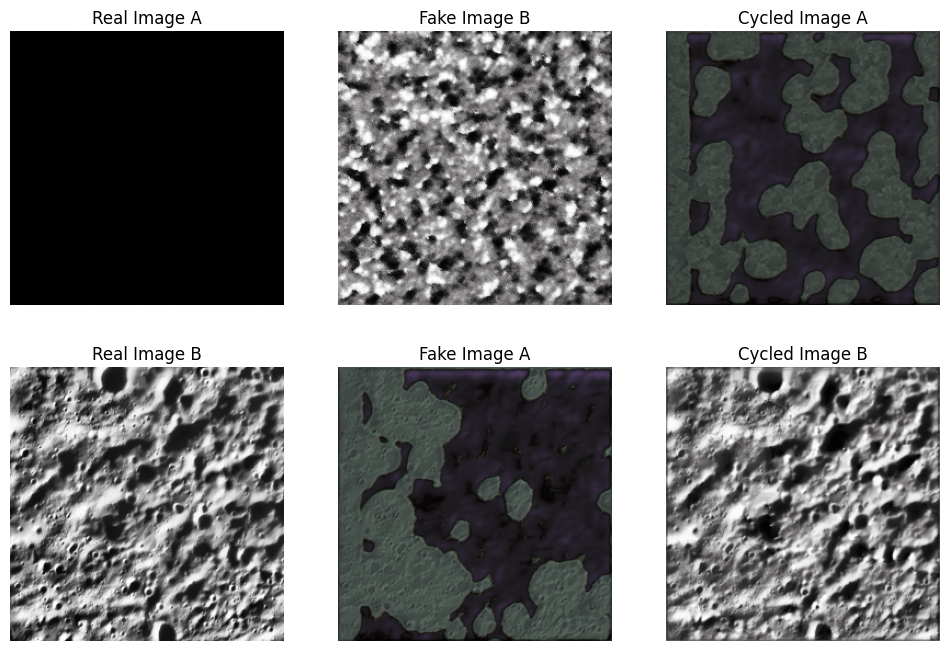

✅ Saved generator_AB to: /content/generator_AB_step2500_epoch1.h5
Epoch 1/50 - Step 2501/2693 | GenAB: 1.9749 | GenBA: 3.7888 | DiscA: 0.1488 | DiscB: 1.4321 | CycleA: 0.4759 | CycleB: 0.2449 | IdA: 0.4410 | IdB: 0.1263
Epoch 1/50 - Step 2502/2693 | GenAB: 2.0727 | GenBA: 4.2245 | DiscA: 0.0882 | DiscB: 1.0521 | CycleA: 0.3486 | CycleB: 0.3004 | IdA: 0.3290 | IdB: 0.1505
Epoch 1/50 - Step 2503/2693 | GenAB: 2.2937 | GenBA: 4.9702 | DiscA: 0.0439 | DiscB: 1.2013 | CycleA: 0.4563 | CycleB: 0.2729 | IdA: 0.4396 | IdB: 0.1317
Epoch 1/50 - Step 2504/2693 | GenAB: 1.9410 | GenBA: 5.4198 | DiscA: 0.8499 | DiscB: 1.2693 | CycleA: 0.3129 | CycleB: 0.2441 | IdA: 0.3346 | IdB: 0.1215
Epoch 1/50 - Step 2505/2693 | GenAB: 1.8809 | GenBA: 5.6055 | DiscA: 0.4343 | DiscB: 1.3213 | CycleA: 0.3285 | CycleB: 0.2977 | IdA: 0.3352 | IdB: 0.1466
Epoch 1/50 - Step 2506/2693 | GenAB: 1.6783 | GenBA: 5.7443 | DiscA: 4.9674 | DiscB: 1.3469 | CycleA: 0.2837 | CycleB: 0.2337 | IdA: 0.2845 | IdB: 0.1301
Epoch 1/50

KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
import os
import numpy as np
from google.colab import drive

drive.mount('/content/drive')

# Paths
raw_folder = '/content/drive/MyDrive/Colab Notebooks/New data/Raw'
enhanced_folder = '/content/drive/MyDrive/Colab Notebooks/New data/Enhanced'

# Preprocessing function for enhanced images
def preprocess_enhanced_image(image):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = image / 255.0  # Normalize
    image = tf.image.resize(image, [500, 500])
    return image

# Preprocessing function for raw images (darkness + speckle noise)
def preprocess_raw_image(image):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = image / 255.0
    image = tf.image.resize(image, [500, 500])

    # Stronger darkness: reduce brightness more
    image = image * tf.random.uniform([], 0.4, 0.7)

    # Stronger speckle noise: higher stddev
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.08)
    image = image + image * noise
    image = tf.clip_by_value(image, 0.0, 1.0)

    return image


# Dataset loader
def load_dataset(folder_path, preprocess_fn, batch_size=1):
    os.chmod(folder_path, 0o755)
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        folder_path,
        label_mode=None,
        image_size=(500, 500),
        batch_size=batch_size,
        shuffle=True
    )
    dataset = dataset.map(lambda x: preprocess_fn(x))
    return dataset

# Load both datasets
dataset_A = load_dataset(raw_folder, preprocess_raw_image, batch_size=1)
dataset_B = load_dataset(enhanced_folder, preprocess_enhanced_image, batch_size=1)

# Assuming train() is defined elsewhere
train(dataset_A, dataset_B, epochs=50, batch_size=1, steps_per_epoch=min(len(dataset_A), len(dataset_B)))
